<a href="https://colab.research.google.com/github/ArturoAntonioSotoOsornio/DMUNAM2025/blob/BesneCabreraAlberto_317012743/Pr%C3%A1ctica3_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Librerías y visualización previa

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

df = pd.read_csv('/content/titanic.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   float64
 1   survived   1309 non-null   float64
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   float64
 6   parch      1309 non-null   float64
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(7), object(7)
memory usage: 143.4+ KB
None
   pclass  survived                                             name     sex  \
0     1.0       1.0                    Allen, Miss. Elisabeth Walton  female   
1     1.0       1.0               

##Trabajando valores faltantes

- Age: Imputamos con la mediana
- Embarked: Imputamos con "mode"
- Cabin: muchos valores faltantes y no representa mucha influencia en el modelado
- Boat/Body: sin utilidad para predecir
- Home.dest: tampoco necesario para predecir

In [2]:
print("Missing values in 'survived':", df['survived'].isna().sum())
df = df.dropna(subset=['survived'])

Missing values in 'survived': 1


## Clasificación de variables
Clasificar en variables numéricas o categóricas

In [3]:
df['title'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df = df.drop('name', axis=1)

# Group rare titles
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr',
               'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
df['title'] = df['title'].replace(rare_titles, 'Rare')
df['title'] = df['title'].replace('Mlle', 'Miss')
df['title'] = df['title'].replace('Ms', 'Miss')
df['title'] = df['title'].replace('Mme', 'Mrs')

## Pre-entrenamiento
Definimos variables y partición de nuestro conjunto de datos

In [4]:
X = df.drop('survived', axis=1)
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked', 'title']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

##Construyendo los modelos

#Red Neuronal

In [10]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=5000,
                  learning_rate='adaptive', early_stopping=True, random_state=42)
nn.fit(X_train_preprocessed, y_train)
y_pred_nn = nn.predict(X_test_preprocessed)
print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")

Neural Network Accuracy: 0.7634


#Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train_preprocessed, y_train)
y_pred_rf = rf.predict(X_test_preprocessed)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

Random Forest Accuracy: 0.8588


#AdaBoost

In [7]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train_preprocessed, y_train)
y_pred_ada = ada.predict(X_test_preprocessed)
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_pred_ada):.4f}")

AdaBoost Accuracy: 0.8359


#Análisis discriminante

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_preprocessed, y_train)
y_pred_lda = lda.predict(X_test_preprocessed)
print(f"LDA Accuracy: {accuracy_score(y_test, y_pred_lda):.4f}")

LDA Accuracy: 0.8473


#Máquina de Soporte vectorial

In [9]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm.fit(X_train_preprocessed, y_train)
y_pred_svm = svm.predict(X_test_preprocessed)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")

SVM Accuracy: 0.8473


#Evaluación del mejor modelo

Utilizaremos "cross-validation" y "hyperparameter tuning" para los mejores modelos

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    return metrics

# Evaluar todos los modelos
models = {'Random Forest': rf, 'SVM': svm}
results = {name: evaluate_model(model, X_test_preprocessed, y_test) for name, model in models.items()}

# Convertir a DataFrame para visualización
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

               Accuracy  Precision  Recall  F1-Score   ROC AUC
Random Forest  0.858779   0.846154    0.77  0.806283  0.895247
SVM            0.847328   0.819149    0.77  0.793814  0.869352


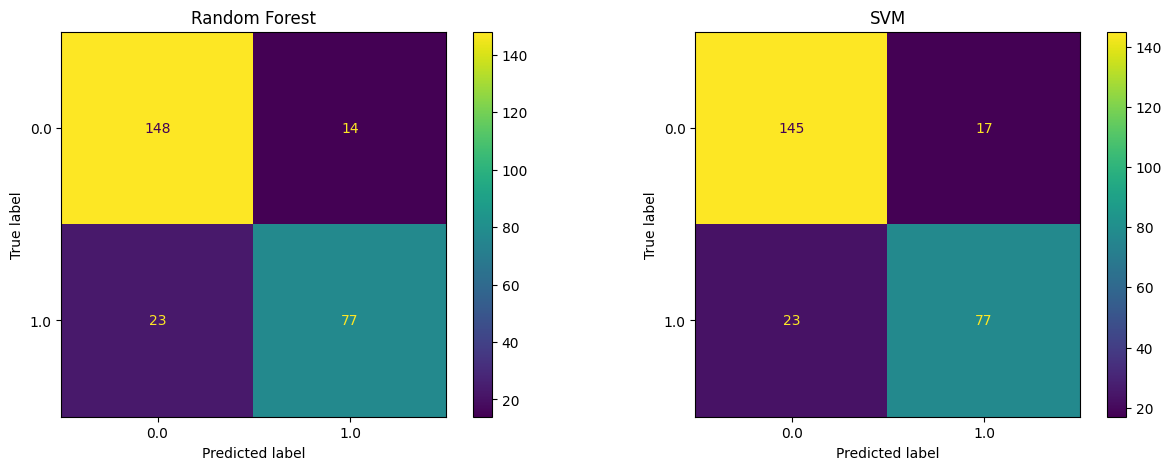

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, (name, model) in zip(axes, models.items()):
    ConfusionMatrixDisplay.from_estimator(model, X_test_preprocessed, y_test, ax=ax)
    ax.set_title(name)
plt.show()

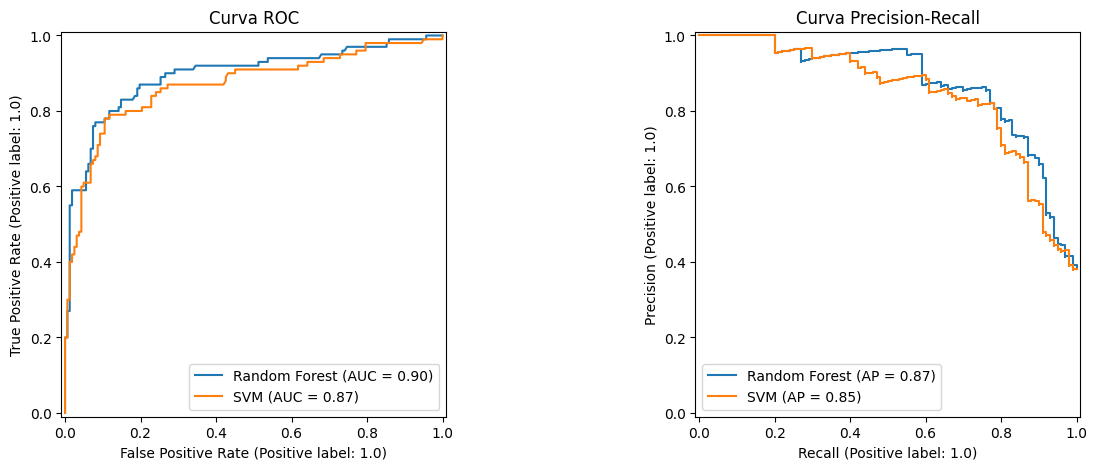

In [23]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test_preprocessed, y_test, ax=ax1, name=name)
    PrecisionRecallDisplay.from_estimator(model, X_test_preprocessed, y_test, ax=ax2, name=name)
ax1.set_title('Curva ROC')
ax2.set_title('Curva Precision-Recall')
plt.show()

#Cocnlusiones

- Matrices de confusión:

1. Ambos modelos tienen un desempeño similar, pero Random Forest tiene una leve ventaja, con menos falsos negativos (14 vs. 17) en la clase 0.

2. Los falsos positivos (23) en la clase 1 son iguales en ambos modelos.

3. Random Forest parece clasificar mejor la clase 0, ya que predice correctamente 148 casos en comparación con 145 de SVM.

- Curva ROC:

1. Random Forest tiene un AUC de 0.90, mientras que SVM tiene un AUC de 0.87.

2. Esto indica que Random Forest tiene un mejor balance entre sensibilidad y especificidad, aunque la diferencia no es muy grande.

- Curva Precision-Recall:

1. Random Forest tiene AP (Área bajo la curva Precision-Recall) de 0.87, mientras que SVM tiene AP de 0.85.

2. Un mayor AP sugiere que Random Forest tiene un mejor desempeño en la clasificación de la clase positiva (cuando el dataset es desbalanceado, esta métrica es más relevante que ROC).

El modelo basado en Random Forest es más efectivo para predecir la supervivencia de los pasajeros del Titanic, logrando un mejor equilibrio entre precisión y recall. Si el objetivo es identificar correctamente a los sobrevivientes, Random Forest es la mejor opción. No obstante, el desempeño de SVM también es aceptable, aunque con una leve inferioridad en la clasificación de los sobrevivientes.